# Kmeans algorithms: Dask implementation

Group_03: Bellentani Giulia 2027590, Monti Sebastiano 2052399, Tonazzo Valentina 2060939 

## Cluster initialization

In [1]:
from dask.distributed import Client, SSHCluster

n_VM = 3 
n_workers = 3 #Benchmarking parameter
n_threads = 2 #Benchmarking parameter

cluster = SSHCluster(
    ["10.67.22.234", "10.67.22.234", "10.67.22.66", "10.67.22.107"],
    worker_options={"n_workers": n_workers, "nthreads": n_threads },
    scheduler_options={"port": 0, "dashboard_address": ":8585"}
)
client = Client(cluster)

distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.234:44849
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.66:43919'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.66:39189'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.66:46463'
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/home/tonazzo/dask-worker-space/worker-x0b359kd', purging
distributed.deploy.ssh - INFO - distributed.diskutils - INFO - Found stale lock file and directory '/home/tonazzo/dask-worker-space/worker-l8jp

## Libraries

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.datasets import make_blobs, fetch_kddcup99 
from sklearn import metrics
from sklearn.cluster import KMeans

import dask
from dask import delayed
import dask.dataframe as dd
import dask.array as da
from dask_ml.cluster import KMeans
from dask_ml.metrics import pairwise_distances
from dask_ml.metrics import pairwise_distances_argmin_min

## Functions

The unsupervised k-means clustering is an algorithm that aims to partition $n$ data points into $k$ clusters in which each point belongs to the cluster with the nearest mean (i.e. cluster centroid).
The goal of k-means clustering is to choose a set $C$ of $k$ centers that minimizes the cost function, that is the sum of the minimum distances between each point and its currently assigned centroid. For this purpose, we need to combine an inizialization algorithm, that provides the initial set of centroids, and an iterative part ("Lloyd's iteration") that will be discussed later on. Now we focus on the possible initilization algorithms, the more used are three: random initialization, k-means++ and k-means parallel.

#### Random Initialization
The classical and most simple initialization of k-means algorithm involves the random selection of $k$ samples among the entire dataset. At each iteration of the Lloyd's algorithm, input points are then assigned to the nearest center and then centers are recomputed at random, given the new point assignment. The drawback of this technique is that, with dataset sizes' growth, classical k-means algorithm turned to be inefficient and low quality. In fact running time can be exponential in worst cases and, even though the final solution is locally optimal, it can be far away from the global optimum.

#### K-means++
k-means++ is an improvement of k-means initialization procedure that results in better performances both in terms of quality and convergence properties. In this initialization just the first center is selected uniformly at random from the data. Each subsequent center is then selected according to a probability distribution that is proportional to its contribution to the overall error, given the previous selections. The probability distribution is given by the following formula.

$p_x = \frac{d^2 \left( x, C \right)}{\phi_X \left( C \right)}$

where $d \left( x, C \right) = \min_{c \in C} || x - c ||$ is the distance of point $x$ of dataset $X$ from the set of cluster centers $C$ and the following holds $\phi_X \left( C \right) = \sum_{x \in X} d^2 \left( x, C \right) = \sum_{x \in X} \min_{i = 1, \dots, k} || x - c_i ||$. 

Intuitively, the algorithm weights more candidate centers that are far away from previously selected centers, since a good clustering should be relatively spread out. The downside of k-means++ is that its total running time is in the order of $n \cdot k \cdot d$ (where k is the number of desired clusters, n is the total number of data samples and d is their dimensionality) and this becomes a problem in the context of massive datasets. Moreover, k-means++ is not apparently parallelizable, since the probability with which a point is chosen to be a candidate center depends on the previously selected centers, revealing an intrinsic sequential nature.

#### K-means||
While random initialization selects k centers in a single iteration and k-means++ just selects one, k-means||, proposed by Bahmani et al. [1], is a solution in between, in which the expected number of selected centers in each iteration is tuned by a parameter $l$, named oversampling factor. In this implementation the first center $c_1$ is computed uniformly at random from the dataset $X$ and the number of iterations is computed as $\log \left( \psi \right)$ where $\psi = \phi_X \left( c_1 \right)$. At each iteration, each $x \in X$ is sampled independently with a probability

$p_x = \frac{l \cdot d^2 \left( x, C \right)}{\phi_X \left( C \right)}$

At the end of the iterations we end up with an expected number of centers equal to $l \cdot log \left( \psi \right)$, which is typically greater than $k$. In order to reduce the number of centers, weights are assigned to the points in $C$ and a reclustering is performed in order to obtain $k$ centers. The details of of the algorithms are written below:

1. $C \, \leftarrow$  Sample a point uniformly at random from $X$
2. $\psi \leftarrow \phi_X \left( C \right)$
3. For $O \left( \log \left( \psi \right) \right)$ times do:
4. $\,\,\,\,\, C' \, \leftarrow$ Sample each point $x \in X$ independently with probability $p_x = \frac{l \cdot d^2 \left( x, C \right)}{\phi_X \left( C \right)}$
5. $\,\,\,\,\, C \leftarrow C \cup C'$
6. End for
7. For $x \in C$, set $w_x$ to be the number of points in $X$ closer to $x$ than any other point in $C$
8. Recluster the weighted points in $C$ into $k$ clusters

#### Lloyd's Iteration

Given the initial set of centroids from any one of the inizialization algorithms, then the next step is what is known as "Lloyd's iteration". Here the input data are compared to the aforemetioned set: each point is assigned to the label of the nearest centroid and then all the points pertaining to the same centroids are summed up, thanks to the dask function pairwise_distances_argmin_min and to our custom made centroids_assignment function. Now the only missing part needed to find the new set of centroids is dividing all these sums for the respective number of points, practically performing one mean for each cluster label and so composing a new set of centroids: for this purpose we exploit the dask bincount function and then we divide the sums by its results. The iteration stops and the algorithm converges when the new centroids are close to the previous ones with an absolute tolerance of $ t = 10^{-2} $.

We will compare our results with the ones obtained by the default dask kmeans algorithm, aiming to go as near as possible to their computation time, especially regarding the k-means parallel initialization (the more suitable for us, because it provides better initialization guesses than the random one, but not sacrifices completly parallelization as k-means++). 

We will also go through a benchmarking phase to see in which initial configurations the computation time seems lower, trying different combinations of the number of dask workers, the number of dask threads and the number of data partitions.

[1] Bahmani, Bahman, et al. "Scalable k-means++." arXiv preprint arXiv:1203.6402 (2012).

In [3]:
#KMEANS RANDOM INITIALIZATION

def init_random(X, X_size, n_centroids):
    idx = np.random.randint(0, X_size, size = n_centroids)
    centroids = X[idx].compute()
    return centroids

In [4]:
#KMEANS PLUS PLUS INITIALIZATION

def init_pp(X, X_size, n_centroids):
    centroids = X[np.random.choice(X_size, 1), :].compute()
    while centroids.shape[0] < n_centroids:
        prob = ((pairwise_distances(X, centroids).min(axis = 1)**2) / (pairwise_distances(X, centroids).min(axis = 1)**2).sum())
        sampled_centroid = X[np.random.choice(X_size, size = 1, p = prob), :].compute()
        centroids = np.append(centroids, sampled_centroid, axis = 0)
    return centroids

In [5]:
#Kmeans|| in cui il reclustering viene fatto utilizzando kmeans ++ di sklearn

def init_par(X, X_size, n_centroids, l):
    centroids = X[np.random.choice(X_size, 1), :].compute()
    log_psi = da.log((pairwise_distances(X, centroids).min(axis = 1)**2).sum()).compute()
    
    for j in range(round(log_psi)):
        prob = (l * (pairwise_distances(X, centroids).min(axis = 1)**2) / (pairwise_distances(X, centroids).min(axis = 1)**2).sum())
        sampled_centroids = X[prob > np.random.uniform(size = X_size)]
        centroids = np.concatenate((centroids, sampled_centroids.compute()))
        
    km = KMeans(n_centroids, random_state = 0, init = "k-means++").fit(centroids)
    
    
       
    return km.cluster_centers_

In [6]:
#function to apply inside blockwise iteration 

def centroids_assignment(X, cluster_label, n_centroids):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    centers = np.zeros((n_centroids, n_features), dtype=np.float64)

    for i in range(n_samples):
        for j in range(n_features):
            centers[cluster_label[i], j] += X[i, j]

    return centers

In [7]:
#LLOYD'S ITERATION

def KMeans_loop(X, n_centroids, centroids, max_iter = 50): 
     
    iterations = 0
    
    while iterations < max_iter: 

        cluster_label, _ = pairwise_distances_argmin_min(
                X, centroids, metric = "euclidean", metric_kwargs = {"squared": True}) #dask_array  (494021, )     

        
        r = da.blockwise(centroids_assignment, "ij", X, "ij", cluster_label, "i", n_centroids, None, "i", adjust_chunks = {"i": n_centroids, "j": X.shape[1]}, dtype = X.dtype)
            
        new_Centroids = da.from_delayed(sum(r.to_delayed().flatten()), (n_centroids, X.shape[1]), X.dtype) 

        
        counts = da.bincount(cluster_label, minlength = n_centroids)
        
        counts = da.maximum(counts, 1)  #to avoid division by 0
        
        new_Centroids = new_Centroids / counts[:, None]
        (new_Centroids,) = da.compute(new_Centroids)
        
                
        if da.allclose(centroids, new_Centroids, atol = 1e-2, equal_nan = True):
            print("Convergence after:", iterations, "iterations")
            break 
            
        centroids = new_Centroids
        iterations += 1
        #print(iterations)
        
    return({"Iterations before convergence": iterations, 
            "Centroids": centroids, 
            "Labels": cluster_label})

In [8]:
def replacement(dataf, arr):
    for j in range(len(arr)):
        dataf = dataf.replace(arr[j], j) #j-th string is substituted with integer number j in each row
    return dataf  

## Randomly generated data analysis

In this section we run our implemented functions on a randomly generated "blob" dataset, just for visualization purposes.

In [9]:
N = 500
feat = 3
n_cent = 5
l = 2 #Oversampling factor

In [10]:
data, labels, c_coord = make_blobs(n_samples = N, n_features = feat, centers = n_cent, random_state = 0, return_centers = True)

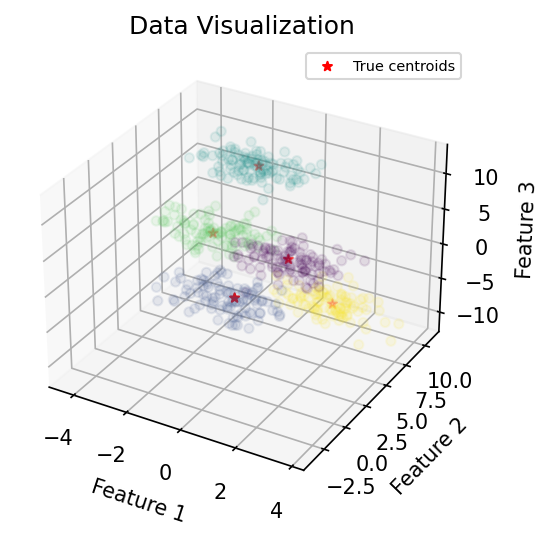

In [11]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha = 0.1, c = labels)
ax.scatter(c_coord[:, 0], c_coord[:, 1], c_coord[:, 2], c = 'red', marker = "*", label = "True centroids", s = 20)
ax.set_title("Data Visualization")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.legend(fontsize = 'x-small')

In [12]:
trial_ddf = dd.from_array(data)
trial_ddf = trial_ddf.repartition(n_workers * n_VM) 

In [13]:
trial_ddf

,0,1,2
npartitions=9,,,
0,float64,float64,float64
55,...,...,...
...,...,...,...
443,...,...,...
499,...,...,...


In [14]:
trial_da = trial_ddf.to_dask_array(lengths = True)

In [15]:
trial_da

dask.array<values, shape=(500, 3), dtype=float64, chunksize=(57, 3), chunktype=numpy.ndarray>

### Ramdomly generated dataset: clustering

In [16]:
%%time 
#KMEANS RANDOM 
init_random_centroids = init_random(X = trial_da, X_size = N, n_centroids = n_cent) 
kmeans_rand = KMeans_loop(X = trial_da, n_centroids = n_cent, centroids = init_random_centroids)

Convergence after: 19 iterations
CPU times: user 1.49 s, sys: 62.9 ms, total: 1.56 s
Wall time: 10.3 s


In [17]:
%%time 
#KMEANS PLUS PLUS
init_pp_centroids = init_pp(X = trial_da, X_size = N, n_centroids = n_cent)
kmeans_pp = KMeans_loop(X = trial_da, n_centroids = n_cent, centroids = init_pp_centroids)

Convergence after: 3 iterations
CPU times: user 465 ms, sys: 24.5 ms, total: 490 ms
Wall time: 1.67 s


In [18]:
%%time 
#KMEANS PAR
init_par_centroids = init_par(X = trial_da, X_size = N, n_centroids = n_cent, l = l) #l=2, see section above
kmeans_par = KMeans_loop(X = trial_da, n_centroids = n_cent, centroids = init_par_centroids)

Convergence after: 3 iterations
CPU times: user 994 ms, sys: 31.5 ms, total: 1.03 s
Wall time: 6.25 s


In [19]:
KM_summary = {0: [kmeans_rand['Centroids'], "random"], 1: [kmeans_pp['Centroids'], "kmeans ++"], 2: [kmeans_par['Centroids'], "kmeans ||"]}

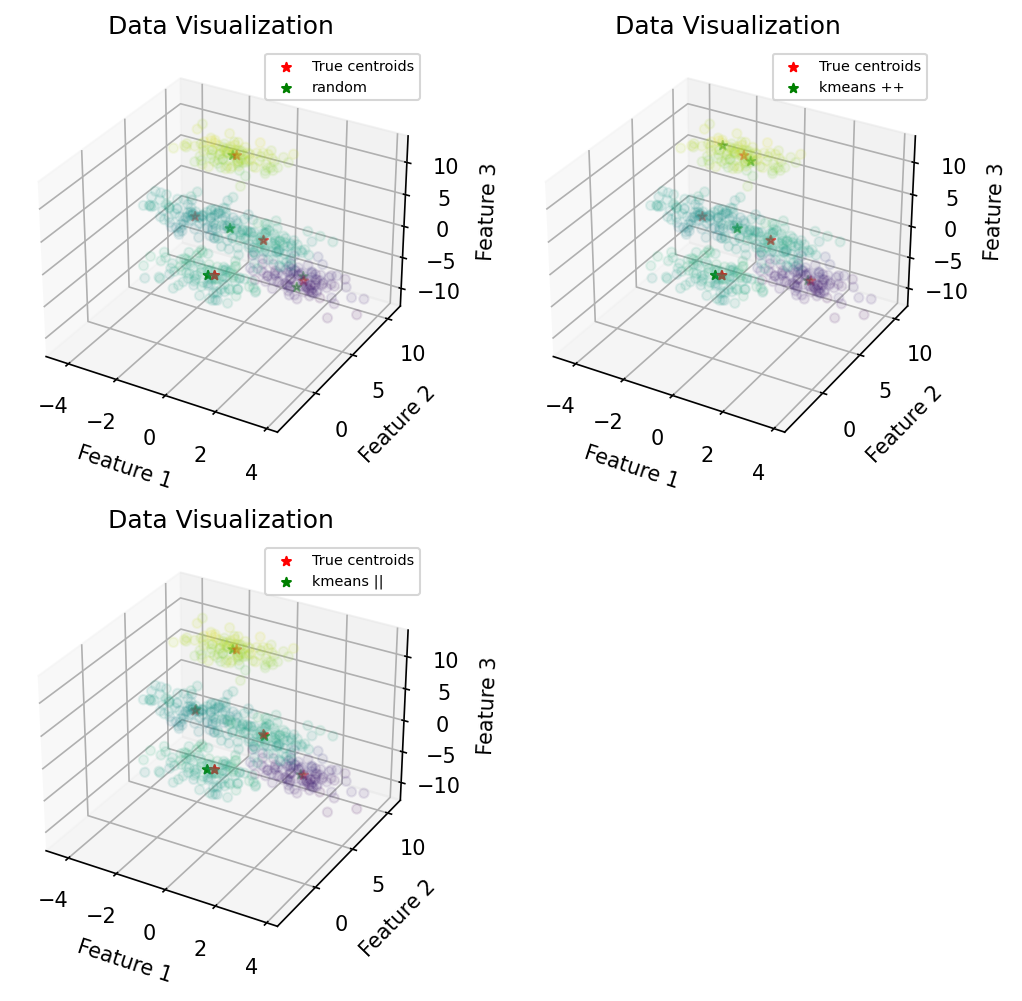

In [20]:
fig = plt.figure(figsize = (8, 8), dpi = 150)
ax = []

for i in range(3):
    ax = np.append(ax, plt.subplot(2, 2, i+1, projection='3d'))
    ax[i].scatter(data[:, 0], data[:, 1], data[:, 2], alpha = 0.1, c = data[:, 2])
    ax[i].scatter(c_coord[:, 0], c_coord[:, 1], c_coord[:, 2], c = 'red', marker = "*", label = "True centroids", s = 20)
    ax[i].scatter(KM_summary[i][0][:, 0], KM_summary[i][0][:, 1], KM_summary[i][0][:, 2], c = 'green', marker = "*", label = KM_summary[i][1], s = 20)
    ax[i].set_title("Data Visualization")
    ax[i].set_xlabel("Feature 1")
    ax[i].set_ylabel("Feature 2")
    ax[i].set_zlabel("Feature 3")
    ax[i].legend(fontsize = 'x-small')

# KDDcup99 dataset analysis

KDDCup99 is a dataset containing tcpdump portions of the 1998 DARPA intrusion detection system evaluation dataset, created by MIT Lincoln Lab. Artificial data was generated using a closed network and hand injected attacks to produce a large number of different types of attack with normal activity in the background. The full dataset contains 4898431 samples and each of them is composed by 41 features.  

Relying on results obtained by Bahmani et al. [1] in their proposed architecture of Scalable K-Means++, we chose to fix the number of desired cluster $k = 65$ and oversampling factor $l = 4 \cdot k$ for two main reasons. Firstly, because in the article is shown that a choice of $k = 65$, or $k = 129$, and $l = 4 \cdot k$ leads to a monotonically decreasing clustering cost (after completing Lloyd's iteration) with respect to the number of rounds. Lastly, because we thought that a relatively high number of centers would have been challenging for clusterization, however after some tests on our available cluster architecture, we saw that choosing $k = 129$ would have been unfeasible due to memory issues. For these reasons, the final decision was to fix $k = 65$.

[1] Bahmani, Bahman, et al. "Scalable k-means++." arXiv preprint arXiv:1203.6402 (2012).

## KDDCup99 dataset: preprocessing

We encountered many problems in opening directly as a dask dataframe both the complete and the reduced versions of the dataset, due to issues related to the function dask.dataframe.read_csv that we did not manage to solve. Moreover, the few times we were able to read the complete dataset, kernel always died during preprocessing. For these reasons, even if not aligned with a proper parallelization procedure, we decided to upload the dataset as a pandas dataframe and then to convert it into a dask dataframe for preprocessing convenience and finally into a dask array.     

In this first part of preprocessing we upload the dataset and replace the three string columns with integer columns.

In [21]:
n_partitions = 24 #Benchmarking parameter
n_centroids = 65 #Fixed
l = round(4 * n_centroids) #Fixed

In [22]:
kdd = fetch_kddcup99() 

In [23]:
ddf_rows, ddf_cols = kdd.data.shape
print(ddf_rows)
print(ddf_cols)

494021
41


In [24]:
df = pd.DataFrame(kdd.data)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [25]:
ddf = dd.from_pandas(df, npartitions = n_partitions) 

In [26]:
col1 = ddf.loc[:, 1].unique() 
col2 = ddf.loc[:, 2].unique() #.loc makes sense only if it retrieves all row values  
col3 = ddf.loc[:, 3].unique() 

In [27]:
col1, col2, col3 = dask.compute(col1, col2, col3)

In [28]:
ddf = replacement(ddf, col1)
ddf = replacement(ddf, col2)
ddf = replacement(ddf, col3)

ddf = ddf.drop(columns = 19) #Column 19 just contains zeros both in the complete and reduced datasets
ddf = ddf.drop(columns = 20) #Column 20 just contains zeros only in the reduced dataset
ddf = ddf.astype('float64')

In [29]:
ddf_cols -= 2

At this point we normalize each column of the dataframe in terms of their means and standard deviations. This should ease the computation of the centroids.

In [30]:
means = ddf.mean()
stds = ddf.std()    

In [31]:
means_res, stds_res = dask.compute(means, stds)

In [32]:
ddf = ddf.apply(lambda record: (record - means_res) / stds_res, axis = 1, meta={0: 'float64', 1: 'float64', 2: 'float64', 3: 'float64', 4: 'float64', 5: 'float64', 6: 'float64', 7: 'float64', 8: 'float64', 9: 'float64', 10: 'float64', 11: 'float64', 12: 'float64', 13: 'float64', 14: 'float64', 15: 'float64', 16: 'float64', 17: 'float64', 18: 'float64', 21: 'float64', 22: 'float64', 23: 'float64', 24: 'float64', 25: 'float64', 26: 'float64', 27: 'float64', 28: 'float64', 29: 'float64', 30: 'float64', 31: 'float64', 32: 'float64', 33: 'float64', 34: 'float64', 35: 'float64', 36: 'float64', 37: 'float64', 38: 'float64', 39: 'float64', 40: 'float64'})

Now we pass from dask dataframe to dask array: dask arrays are the default inputs for k-means functions.

In [33]:
arr = ddf.to_dask_array(lengths=True)

In [34]:
arr

dask.array<values, shape=(494021, 39), dtype=float64, chunksize=(20585, 39), chunktype=numpy.ndarray>

In [35]:
del ddf, col1, col2, col3, data, labels, c_coord, trial_ddf, trial_da

In [36]:
client.restart()

<Client: 'tcp://10.67.22.234:44849' processes=3 threads=6, memory=11.66 GiB>

In [37]:
arr = client.persist(arr)

In [38]:
print(arr)

dask.array<values, shape=(494021, 39), dtype=float64, chunksize=(20585, 39), chunktype=numpy.ndarray>


In [39]:
print(arr.partitions.shape)
print(arr.partitions[0].shape)

(24, 1)
(20585, 39)


# KDDcup dataset: clustering and benchmarking

### OUR RANDOM INITIALIZATION AND LLOYD'S ALGO

In [40]:
%%time

init_random_centroids = init_random(X = arr, X_size = ddf_rows, n_centroids = n_centroids)
kmeans_rand = KMeans_loop(X = arr, n_centroids = n_centroids, centroids = init_random_centroids)

CPU times: user 7.97 s, sys: 254 ms, total: 8.23 s
Wall time: 2min 22s


### OUR ++ INITIALIZATION AND LLOYD'S ALGO

In [41]:
%%time

init_pp_centroids = init_pp(X = arr, X_size = ddf_rows, n_centroids = n_centroids)
eans_pp = KMeans_loop(X = arr, n_centroids = n_centroids, centroids = init_pp_centroids)

Convergence after: 20 iterations
CPU times: user 7.87 s, sys: 492 ms, total: 8.36 s
Wall time: 1min 8s


### OUR || INITIALIZATION AND LLOYD'S ALGO

In [42]:
%%time
#%%timeit -r4

init_par_centroids = init_par(X = arr, X_size = ddf_rows, n_centroids = n_centroids, l = l)
kmeans_par = KMeans_loop(X = arr, n_centroids = n_centroids, centroids = init_par_centroids)

Convergence after: 29 iterations
CPU times: user 7.48 s, sys: 406 ms, total: 7.88 s
Wall time: 1min 52s


### RANDOM INITIALIZATION  DASK DEFAULT ALGORITHM 

In [43]:
%%time

default_kmeans_random = KMeans(n_clusters = n_centroids, init = 'random', tol = 1e-1, max_iter = 50)
random_results = default_kmeans_random.fit(arr)
print(random_results.n_iter_)

45
CPU times: user 5.3 s, sys: 136 ms, total: 5.43 s
Wall time: 25.3 s


### KMEANS ++ INITIALIZATION  DASK DEFAULT ALGORITHM 

In [44]:
%%time

default_kmeans_pp = KMeans(n_clusters = n_centroids, init = 'k-means++', tol = 1e-2, max_iter = 50)
pp_results = default_kmeans_pp.fit(arr)
print(pp_results.n_iter_)

16
CPU times: user 12.5 s, sys: 814 ms, total: 13.3 s
Wall time: 12.8 s


### KMEANS || INITIALIZATION  DASK DEFAULT ALGORITHM

In [45]:
%%time
#%%timeit -r4

default_kmeans_par = KMeans(n_clusters = n_centroids, init = 'k-means||', oversampling_factor = l, max_iter = 50, tol = 1e-2)
par_results = default_kmeans_par.fit(arr)
print(par_results.n_iter_)

14
CPU times: user 7.48 s, sys: 504 ms, total: 7.99 s
Wall time: 47.7 s


# Benchmark of parameters

We varied the number of dask workers (w), the number of dask threads (t) and the number of data partitions (p). Each benchmarking trial was repeated four times, first column indicate the average time result, second column indicates standard deviation 

# Final considerations and plots

One interesting thing that we can see is that using less then the total number of workers available but with more then one thread seems to improve the cluster's performances: although the computational time remains very similar, from the dask dashboard we can observe that operations seems to be more optimized; less white spaces between subsequent tasks indicates that workers stay in an idle state for less time, and also comunication between workers (indicated by red color) is reduced. This lead to an optimized usege of available memory, an this is confermed also from the fact that in this cases no memory is spilled to disk, so performances seems to be more stable. On the other hand, increasing too much the number of threads let workers in idle state leading to poor performances and also computational time inscrease significantly.   

<img src="daskbuona.jpg" alt="Alternative text" />

Comparison between optimized work on dashboard and non optmized


<img src="dashbrutta.jpg" alt="Alternative text" />

All these conclusions, drawn from the timings reported above and from observing the dashboard, are further visible in the subsequent plots.

## PLOTS

### 1) HEATMAPS

In these two first heatmaps, we will compare the results with one and two threads and with [12, 2⋅12=24, 3⋅12=36, 5⋅12=60] partitions, keeping the number of workers fixed (4), for both our algorithm and the default one.
We can immediatly see one big difference between our implementation and the default algorithm: the second one proves to be very stable, obtaining very similar results for all the combinations, except maybe the ones with 60 partitions. This was evident also from the "benchmark_times" list above, where the default times are almost always shorter, and shorter is their standard deviation. 
Instead, for what concerns our version, the different configurations impact the computation times. The results seem better for [(36p,1t),(36p,2t),(60p,2t)], but we have to keep in mind the high standard deviations, respectively (5.48 s,17.9 s,7.42 s).

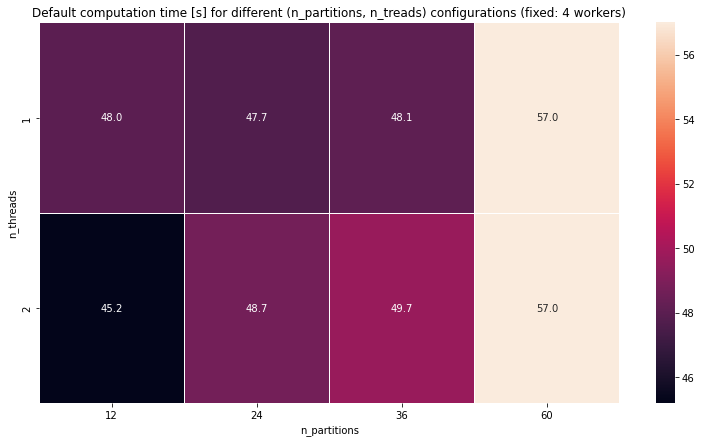

In [46]:
def_heat_df_3vm_4w = pd.DataFrame({'n_threads': [1,1,1,1,2,2,2,2], 'n_partitions': [12,24,36,60,12,24,36,60],
'time' : [48,47.7,48.1,57, 45.2,48.7, 49.7, 57]})

def_heat_piv_3vm_4w  = def_heat_df_3vm_4w.pivot(index='n_threads', columns='n_partitions', values='time')

f, ax = plt.subplots(figsize=(13, 7))
ax.set_title("Default computation time [s] for different (n_partitions, n_treads) configurations (fixed: 4 workers)")
sns.heatmap(def_heat_piv_3vm_4w, annot=True, fmt=".1f", linewidth=.5, ax=ax) #cmap='viridis' cmap='crest'
plt.show()

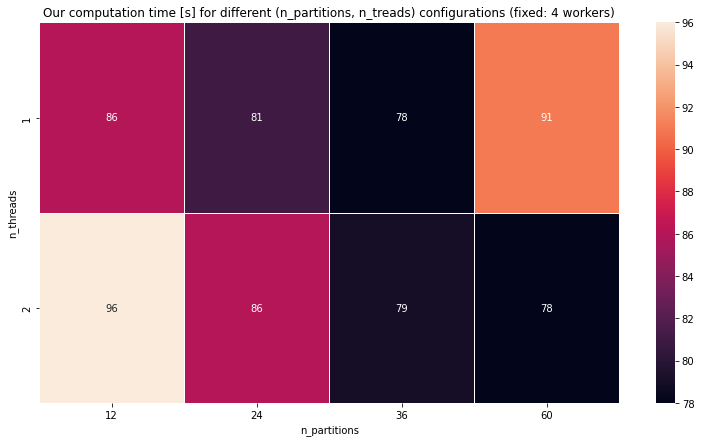

In [47]:
our_heat_df_3vm_4w = pd.DataFrame({'n_threads': [1,1,1,1,2,2,2,2], 'n_partitions': [12,24,36,60,12,24,36,60],
'time' : [86,81,78,91, 96,86,79,78]})

our_heat_piv_3vm_4w  = our_heat_df_3vm_4w.pivot(index='n_threads', columns='n_partitions', values='time')

f, ax = plt.subplots(figsize=(13, 7))
ax.set_title("Our computation time [s] for different (n_partitions, n_treads) configurations (fixed: 4 workers)")
sns.heatmap(our_heat_piv_3vm_4w, annot=True, linewidth=.5, ax=ax) #fmt=".1f" #ax=ax #cmap='viridis' cmap='crest' 
plt.show()

In these two second heatmaps, we will compare the results with two and three workers and with [12, 24, 36, 60] partitions, keeping the number of threads fixed (2), again for both our algorithm and the default one. 
The default algorithm proves to be stable again, both within the different configuration and when compared to the previous default heatmap. It is also constant that it is slightly slower with more partitions (60).

Interestingly, the number of workers seems to impact our algoritm more. As said above, in some configuration the memory seems handled better with less than four worker, and here we can see that the best performance our algorithm reached in our tests (66 s, std: 6.8 s) is indeed with 24 partitions and 3 workers. This is evident also when compared to the two 24 partitions and 4 workers result (86 s, std: 13.7 s) -the number of threads is the same, 2-. So, the better memory managing seen in the dashboard for example for 24 partitions and 3 workers seems to have an impact on the computation time. We will elaborate on that further above the subsequent 2D plots, especially regarding the decrease of the standard deviations.

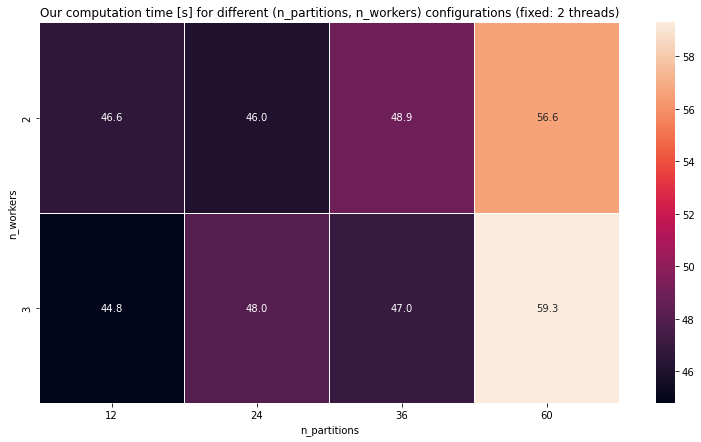

In [48]:
def_heat_df_3vm_2t = pd.DataFrame({'n_workers': [2,2,2,2,3,3,3,3], 'n_partitions': [12,24,36,60,12,24,36,60],
'time' : [46.6,46,48.9,56.6,44.8,48,47,59.3]})

def_heat_piv_3vm_2t  = def_heat_df_3vm_2t.pivot(index='n_workers', columns='n_partitions', values='time')

f, ax = plt.subplots(figsize=(13, 7))
ax.set_title("Our computation time [s] for different (n_partitions, n_workers) configurations (fixed: 2 threads)")
sns.heatmap(def_heat_piv_3vm_2t, annot=True, linewidth=.5, ax=ax, fmt=".1f")  
plt.show()

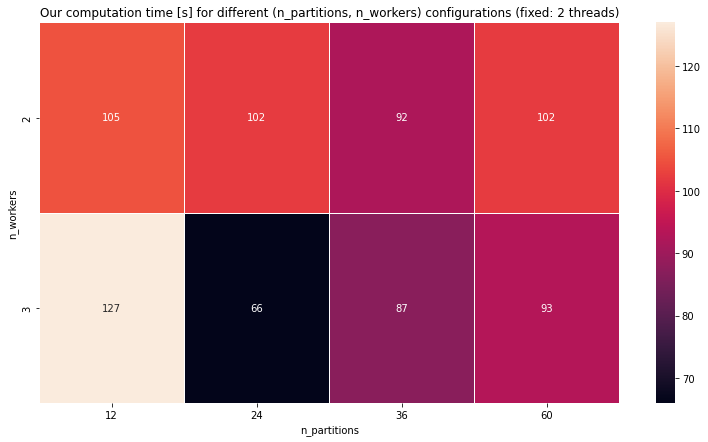

In [49]:
our_heat_df_3vm_2t = pd.DataFrame({'n_workers': [2,2,2,2,3,3,3,3], 'n_partitions': [12,24,36,60,12,24,36,60],
'time' : [105,102,92,102,127,66,87,93]})

our_heat_piv_3vm_2t  = our_heat_df_3vm_2t.pivot(index='n_workers', columns='n_partitions', values='time')

f, ax = plt.subplots(figsize=(13, 7))
ax.set_title("Our computation time [s] for different (n_partitions, n_workers) configurations (fixed: 2 threads)")
sns.heatmap(our_heat_piv_3vm_2t, annot=True, linewidth=.5, ax=ax, fmt='g')  
plt.show()

## 2) 2D PLOTS

In these plots we compare computation times for both algorithms, changing the number of workers from one up to four, but keeping fixed the number of partitions (24). The number of threads changes only among the different plots (1,2,6).

In [50]:
n_workers_x = [1, 2, 3, 4]

Comparing our algorithm's performance in the two subsequent plots (one thread, two threads), we see that for one thread the optimal number of workers is four, but for two threads seems to be three (reaching the aforementioned minimum 66 s, std: 6.8 s).
The default algorithm for one thread benefits from the increasing of the number of workers, for two threads instead its performance seems practically unaffected.

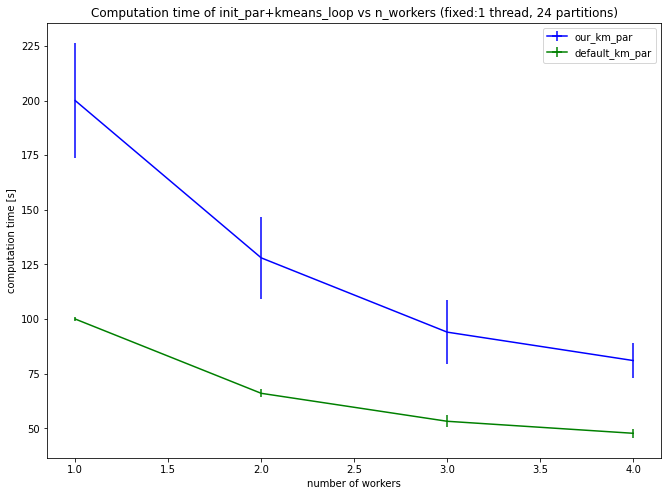

In [51]:
fig, ax = plt.subplots(figsize = (11, 8))
our_n_workers_time_1t_24p = [200, 128, 94, 81]
def_n_workers_time_1t_24p = [100, 66, 53.2, 47.7]
our_y_err_1t_24p = [26.5, 18.7, 14.8, 8.07]
def_y_err_1t_24p = [1.02, 1.81, 2.77, 2.17]
ax.errorbar(n_workers_x, our_n_workers_time_1t_24p, xerr = 0, yerr = our_y_err_1t_24p, label = "our_km_par", c = 'b')
ax.errorbar(n_workers_x, def_n_workers_time_1t_24p, xerr = 0, yerr = def_y_err_1t_24p, label = "default_km_par", c = 'g')
ax.set_xlabel('number of workers')
ax.set_ylabel('computation time [s]')
ax.set_title('Computation time of init_par+kmeans_loop vs n_workers (fixed:1 thread, 24 partitions)')
ax.legend()
plt.show()

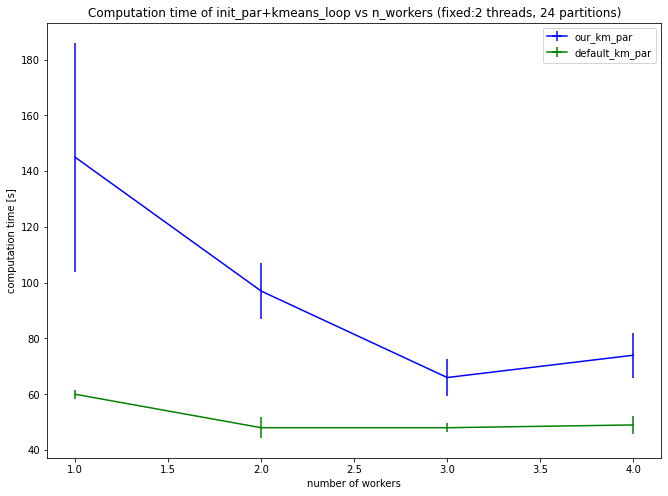

In [52]:
fig, ax = plt.subplots(figsize = (11, 8))
our_n_workers_time_2t_24p = [145, 97, 66, 74]
def_n_workers_time_2t_24p = [60, 48, 48, 49]
our_y_err_2t_24p = [41.1, 10.1, 6.8, 8.08]
def_y_err_2t_24p = [1.68, 3.7, 1.53, 3.37]
ax.errorbar(n_workers_x, our_n_workers_time_2t_24p, xerr = 0, yerr = our_y_err_2t_24p, label = "our_km_par", c = 'b')
ax.errorbar(n_workers_x, def_n_workers_time_2t_24p, xerr = 0, yerr = def_y_err_2t_24p, label = "default_km_par", c = 'g')
ax.set_xlabel('number of workers')
ax.set_ylabel('computation time [s]')
ax.set_title('Computation time of init_par+kmeans_loop vs n_workers (fixed:2 threads, 24 partitions)')
ax.legend()
plt.show()

In this last plot we see that six threads proves to be detrimental for our algorithm, as we mentioned in the "benchmark_times" list: in all configurations except the first one with only one worker, the memory is handled very badly and workers die. This is reflected in the worse computation times and especially in the very high standard deviations. We imagined that at least two factors could in general be behind the increase of the standard deviations: 
1. dying workers and/or spilling memory to the disk
2. instability of our algorithm: the number of iterations needed to reach convergence is sometimes very different among the four trials 

The default agorithm proves to be stable again and also surprisingly reaches one of its best performances for 1 workers and 6 threads.

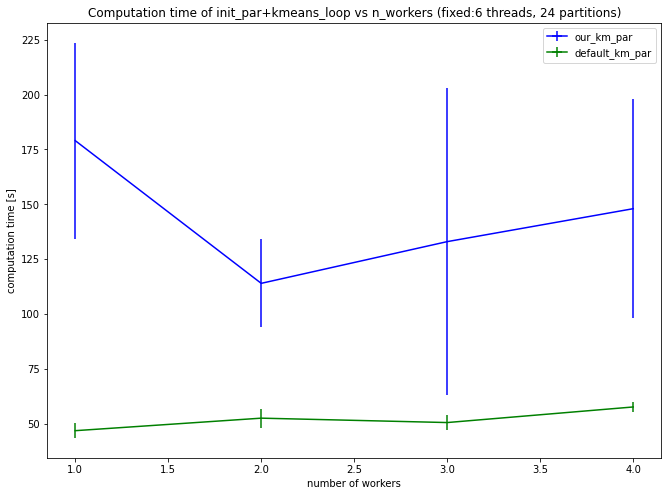

In [53]:
fig, ax = plt.subplots(figsize = (11, 8))
our_n_workers_time_6t_24p = [179, 114, 133, 148]
def_n_workers_time_6t_24p = [46.9, 52.6, 50.6, 57.7]
our_y_err_6t_24p = [44.6, 20.1, 70, 50]
def_y_err_6t_24p = [3.35, 4.3, 3.45, 2.3] 
ax.errorbar(n_workers_x, our_n_workers_time_6t_24p, xerr = 0, yerr = our_y_err_6t_24p, label = "our_km_par", c = 'b')
ax.errorbar(n_workers_x, def_n_workers_time_6t_24p, xerr = 0, yerr = def_y_err_6t_24p, label = "default_km_par", c = 'g')
ax.set_xlabel('number of workers')
ax.set_ylabel('computation time [s]')
ax.set_title('Computation time of init_par+kmeans_loop vs n_workers (fixed:6 threads, 24 partitions)')
ax.legend()
plt.show()

## APPENDIX

In [54]:
#Kmeans|| "all by hand" 1

def init_par_hand(X, X_size, n_centroids, l):
    centroids = X[np.random.choice(X_size, 1), :].compute()
    log_psi = da.log((pairwise_distances(X, centroids).min(axis = 1)**2).sum()).compute()
    
    for j in range(round(log_psi)):
        prob = (l * (pairwise_distances(X, centroids).min(axis = 1)**2) / (pairwise_distances(X, centroids).min(axis = 1)**2).sum())
        sampled_centroids = X[prob > np.random.uniform(size = X_size)]
        centroids = np.concatenate((centroids, sampled_centroids.compute()))
        
    closer_pts, _ = pairwise_distances_argmin_min(X, centroids) 
    closer_pts = closer_pts.compute()
    w_k = np.array([len(closer_pts[closer_pts == i]) for i in range(len(centroids))])
    w_k = w_k / np.sum(w_k)
    centroids = centroids[np.random.choice(len(centroids), size = n_centroids, p = w_k, replace = False), :]
    
    return centroids

In [55]:
#Kmeans|| "all by hand" 2

def init_par_hand(X, X_size, n_centroids, l):
    centroids = X[np.random.choice(X_size, 1), :].compute()
    log_psi = da.log((pairwise_distances(X, centroids).min(axis = 1)**2).sum()).compute()
    
    for j in range(round(log_psi)):
        prob = (l * (pairwise_distances(X, centroids).min(axis = 1)**2) / (pairwise_distances(X, centroids).min(axis = 1)**2).sum())
        sampled_centroids = X[prob > np.random.uniform(size = X_size)]
        centroids = np.concatenate((centroids, sampled_centroids.compute()))
    
    closer_pts, _ = pairwise_distances_argmin_min(X, centroids) 
    unique_values, frequencies = da.unique(closer_pts, return_counts=True) 
    unique_values, frequencies = dask.compute(unique_values, frequencies) 
    top_k_values = unique_values[np.argsort(-frequencies)[:n_centroids]] 
    centroids = centroids[top_k_values]

    return centroids

### Preprocessed file .csv writing/reading  

In [56]:
#GET CSV FILE OF PROCESSED DATA

#pd_ddf = ddf.compute()
#pd_ddf.to_csv("ddf.csv", header = False, index = False, index_label = False, compression = None) 

In [57]:
#df = pd.read_csv("ddf.csv", header = None)
#ddf = dd.from_pandas(df, npartitions = n_partitions)
#arr = ddf.to_dask_array(lengths=True)

In [58]:
#ddf_rows, ddf_cols = df.shape
#print(ddf_rows)
#print(ddf_cols)

In [59]:
#del df, ddf